# Testings for PlesioGeostroPy

In [1]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

import numpy as np
from scipy import special as specfun
import matplotlib.pyplot as plt

from pg_utils.pg_model import base, core

import perfplot
plt.style.use("default")

**Regularity tests** are now removed from this notebook.
For further regularity conditions and tests, see [Demo_Regularity.ipynb](Demo_Regularity.ipynb)

---
## Jacobi polynomial evaluation test

In [2]:
from scipy.special import eval_jacobi, roots_jacobi
from pg_utils.numerics.special import eval_jacobi_to_Nmax, eval_jacobi_nrange

### Precision test

In [10]:
n_range = np.arange(-2, 101)
alpha, beta = 1/2, -1/2
xi, wt = roots_jacobi(101, alpha, beta)
N_mesh, X_mesh = np.meshgrid(n_range, xi, indexing='ij')

- Calculate using the library `scipy.special.eval_jacobi`
- Calculate using the recurrence function `numerics.special.eval_jacobi_array`

In [17]:
Jacobi_val_scipy = eval_jacobi(N_mesh, alpha, beta, X_mesh)
Jacobi_val_recur = eval_jacobi_nrange(n_range[0], n_range[-1], alpha, beta, xi)

Compare the results

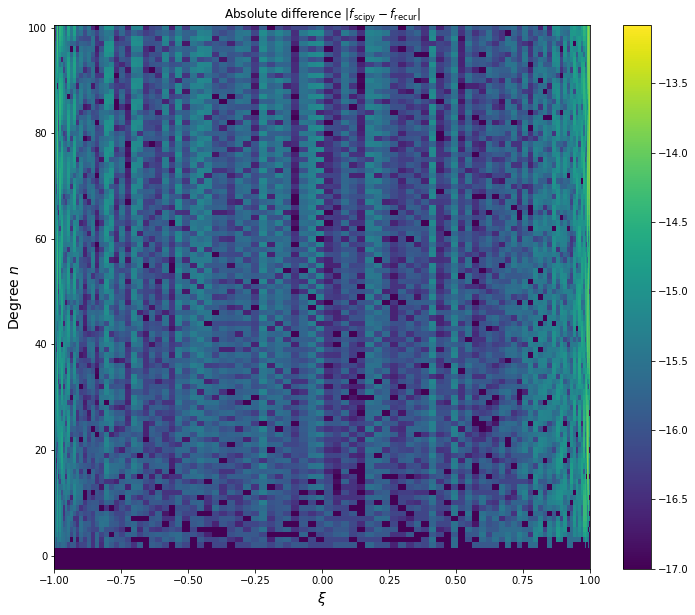

In [18]:
fig, ax = plt.subplots(figsize=(12, 10))

relative_err = np.abs(Jacobi_val_scipy - Jacobi_val_recur) + 1e-17
im = ax.pcolormesh(X_mesh, N_mesh, np.log10(relative_err))
ax.set_xlabel(r"$\xi$", fontsize=14)
ax.set_ylabel("Degree $n$", fontsize=14)
ax.set_title(r"Absolute difference $|f_{\mathrm{scipy}} - f_{\mathrm{recur}}|$")
plt.colorbar(im)

plt.show()

$L_2$-error

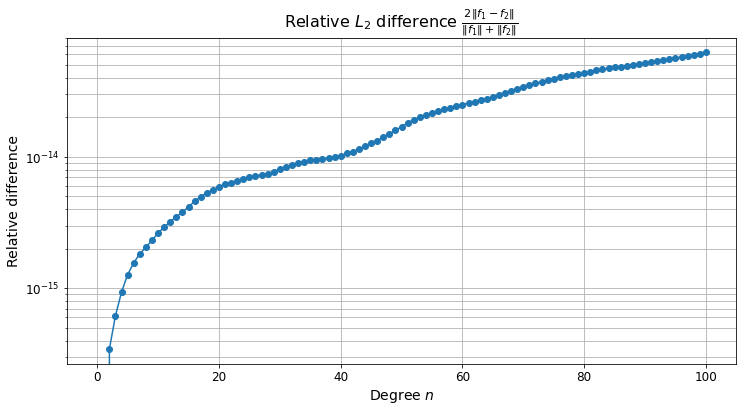

In [19]:
norm_Jacobi_scipy = np.sum(Jacobi_val_scipy**2*wt, axis=-1)
norm_Jacobi_recur = np.sum(Jacobi_val_recur**2*wt, axis=-1)
norm_diff = np.sum((Jacobi_val_scipy - Jacobi_val_recur)**2*wt, axis=-1)

fig, ax = plt.subplots(figsize=(12, 6))

relative_err = np.sqrt(norm_diff[n_range >= 0])/((np.sqrt(norm_Jacobi_recur[n_range >= 0]) + np.sqrt(norm_Jacobi_scipy[n_range >= 0]))/2)
ax.semilogy(n_range[n_range >= 0], relative_err, 'o-')
ax.set_xlabel("Degree $n$", fontsize=14)
ax.set_ylabel("Relative difference", fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_title(r"Relative $L_2$ difference $\frac{2\Vert f_1 - f_2 \Vert}{\Vert f_1\Vert + \Vert f_2\Vert}$", fontsize=16)
ax.grid(which="both")

plt.show()

It therefore seems that what is computed using recurrence relation and what is computed using the library function is different by at most $10^{-13}$, both in the absolute sense and in the relative sense.

### Efficiency test

Define functions for testing

In [33]:
npts_eval = 100

def params_setup(Nmax):
    n_range = np.arange(Nmax + 1)
    alpha, beta = 1/2, -1/2
    xi, _ = roots_jacobi(npts_eval, alpha, beta)
    N_mesh, X_mesh = np.meshgrid(n_range, xi, indexing='ij')
    return n_range, xi, N_mesh, X_mesh, alpha, beta

- Calculate using the library `scipy.special.eval_jacobi`
- Calculate using the recurrence function `numerics.special.eval_jacobi_array`

In [37]:
benchmarks = perfplot.bench(
    setup=params_setup,
    kernels=[
        lambda n_range, xi, N_mesh, X_mesh, alpha, beta: eval_jacobi(N_mesh, alpha, beta, X_mesh),
        lambda n_range, xi, N_mesh, X_mesh, alpha, beta: eval_jacobi_nrange(n_range[0], n_range[-1], alpha, beta, xi)
    ],
    labels=["scipy", "recurrence"],
    n_range=[int(10**(N/5)) for N in range(0, 16)]
)

Output()

Compare the results

In [38]:
benchmarks

┏━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ n    ┃ scipy                  ┃ recurrence             ┃
┡━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ 1    │ 4.000000000000001e-06  │ 1.58e-05               │
│ 1    │ 3.9e-06                │ 1.59e-05               │
│ 2    │ 6.900000000000001e-06  │ 7.340000000000001e-05  │
│ 3    │ 1.08e-05               │ 8.53e-05               │
│ 6    │ 2.9100000000000003e-05 │ 0.0001095              │
│ 10   │ 6.83e-05               │ 0.0001406              │
│ 15   │ 0.00014120000000000002 │ 0.00017820000000000002 │
│ 25   │ 0.0003658              │ 0.0001867              │
│ 39   │ 0.0006339000000000001  │ 0.00021830000000000002 │
│ 63   │ 0.0015598              │ 0.00032750000000000005 │
│ 100  │ 0.003634               │ 0.0004949              │
│ 158  │ 0.0084163              │ 0.0007602              │
│ 251  │ 0.0194942              │ 0.0011781              │
│ 398  │ 0.0466827              │ 0.0018582000000000002  │
│ 630  │ 0.1203501              │ 0.0029213000000000004  │
│ 1000 │ 0.3013965              │ 0.0053087              │
└──────┴────────────────────────┴────────────────────────┘

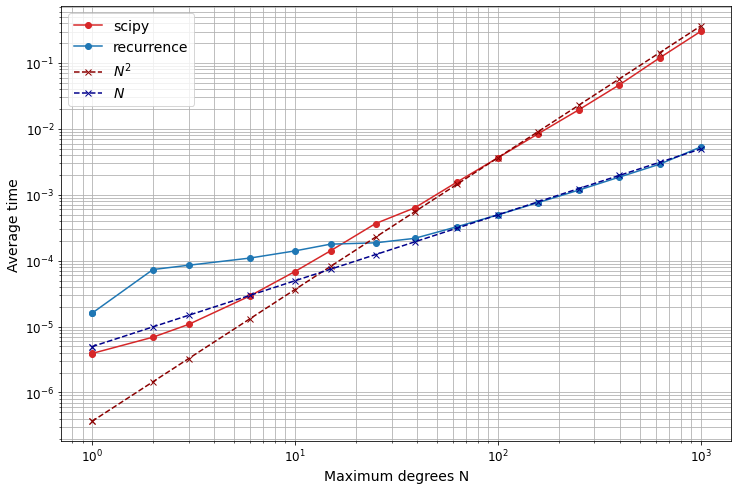

In [39]:
fig, ax = plt.subplots(figsize=(12, 8))

color_list=["tab:red", "tab:blue"]

for i in range(benchmarks.timings_s.shape[0]):
    ax.loglog(benchmarks.n_range, benchmarks.timings_s[i], 'o-', color=color_list[i], label=benchmarks.labels[i])

ax.loglog(benchmarks.n_range, (benchmarks.timings_s[0, -6]/(benchmarks.n_range[-6]**2))*benchmarks.n_range**2, 'x--', color="darkred", label=r"$N^2$")
ax.loglog(benchmarks.n_range, (benchmarks.timings_s[1, -6]/benchmarks.n_range[-6])*benchmarks.n_range, 'x--', color="darkblue", label=r"$N$")

ax.set_xlabel("Maximum degrees N", fontsize=14)
ax.set_ylabel("Average time", fontsize=14)

ax.legend(fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(which="both")
plt.show()

#### Profiler

In [28]:
%lprun -f eval_jacobi_to_Nmax [eval_jacobi_to_Nmax(100, alpha, beta, xi) for i in range(500)]

Timer unit: 1e-07 s

Total time: 0.558725 s
File: C:\Users\gentle\Documents\Projects\PG-Assim\pg_utils\numerics\special.py
Function: eval_jacobi_to_Nmax at line 28

Line #      Hits         Time  Per Hit   % Time  Line Contents
    28                                           def eval_jacobi_to_Nmax(Nmax: int, alpha: float, beta: float, z: np.ndarray):
    29                                               """Evaluate Jacobi polynomials up to a degree
    30                                               """
    31       500       3774.0      7.5      0.1      assert Nmax >= 1
    32                                               # Set computing degrees
    33       500      18143.0     36.3      0.3      n_array = np.arange(Nmax + 1)                                   # O(N)
    34                                               # Initializing the matrix: N * M
    35       500      34665.0     69.3      0.6      Jacobi_vals = np.zeros((n_array.size, z.size), dtype=z.dtype)   # O(MN)
    36 